<a href="https://colab.research.google.com/github/edwinmartin28/MultiVocal-Bus-Net/blob/main/Licence_Plate_Recogination_and_Multilingual_Announcement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/edwinmartin28/MultiVocal-Bus-Net.git

Cloning into 'MultiVocal-Bus-Net'...
remote: Enumerating objects: 85, done.
remote: Counting objects: 100% (85/85), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 85 (delta 7), reused 72 (delta 2), pack-reused 0
Receiving objects: 100% (85/85), 24.97 MiB | 30.55 MiB/s, done.
Resolving deltas: 100% (7/7), done.


In [ ]:
import gdown  # Importing the gdown library for downloading files from Google Drive
import zipfile  # Importing the zipfile library for extracting zip files
from PIL import Image  # Importing the Image module from the Pillow library for image processing
import os  # Importing the os module for interacting with the operating system

# URL of the dataset to be downloaded
url = 'https://drive.google.com/uc?id= --- '

# Path where the downloaded zip file will be saved
output_zip = '/content/dataset.zip'

# Download the dataset from the specified URL and save it to the specified location
gdown.download(url, output_zip, quiet=False)

# Extract the contents of the downloaded zip file
with zipfile.ZipFile(output_zip, 'r') as zip_ref:
    zip_ref.extractall('/content/')

In [3]:
!pip install gtts  # Install the Google Text-to-Speech (gTTS) library for text-to-speech conversion
!pip install easyocr  # Install the EasyOCR library for optical character recognition (OCR)
!pip install ultralytics  # Install the Ultralytics library for computer vision tasks

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 53.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 716.0/716.0 kB 3.8 MB/s eta 0:00:00


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete
0: 640x640 1 LicensePlate, 519.3ms
Speed: 14.0ms preprocess, 519.3ms inference, 23.5ms postprocess per image at shape (1, 3, 640, 640)
Detected Text: KL15A1005
The text 'KL15A1005' is present in column 'NUMBER PLATE'.
Value: PATHANAMTHITTA


CSV file updated successfully.


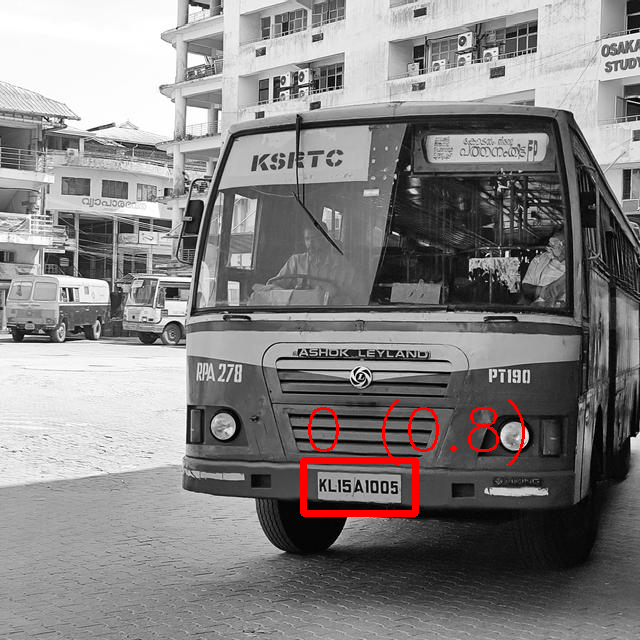

In [4]:
# Import necessary libraries
import os
import cv2
from google.colab.patches import cv2_imshow
import easyocr
from ultralytics import YOLO
from gtts import gTTS
from IPython.display import Audio, display
import pandas as pd
import time

# Function to check text in CSV file and retrieve corresponding values
def check_text_and_retrieve_values(csv_file, column_to_search, text_to_check):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_file)

    # Check if the text is present in the specified column
    if df[column_to_search].str.contains(fr"\b{text_to_check}\b").any():
        # If text is found, get the values from the same row
        row_with_text = df[df[column_to_search].str.contains(fr"\b{text_to_check}\b")]
        column4_value = row_with_text['DECISION'].iloc[0]
        if column4_value == 1:
            value = row_with_text['STARTING POINT'].iloc[0]
            row_index = row_with_text.index[0]
            df.at[row_index, 'DECISION'] = 0
        elif column4_value == 0:
            value = row_with_text['DESTINATION'].iloc[0]
            row_index = row_with_text.index[0]
            df.at[row_index, 'DECISION'] = 1
        print(f"The text '{text_to_check}' is present in column '{column_to_search}'.")
        print(f"Value: {value}")

        # Generate audio files for English, Malayalam, and Hindi
        text_to_speak_en = value
        text_to_speak_ml = value
        text_to_speak_hi = value
        output_audio_en = text_to_speech(text_to_speak_en, language='en')
        output_audio_ml = text_to_speech(text_to_speak_ml, language='ml')
        output_audio_hi = text_to_speech(text_to_speak_hi, language='hi')

        # Display audio files
        display(output_audio_en)
        time.sleep(4)
        display(output_audio_ml)
        time.sleep(3)
        display(output_audio_hi)

        # Write the updated DataFrame back to the CSV file
        df.to_csv(csv_file, index=False)
        print("CSV file updated successfully.")
    else:
        print(f"The text '{text_to_check}' is not present in column '{column_to_search}'.")
        return None

# Function to convert text to speech
def text_to_speech(text, language='en', output_file='output.mp3'):
    if language == 'en':
        # English text
        english_text = f"Bus going to {text} has reached the station"
        tts = gTTS(text=english_text, lang='en', slow=False)
    elif language == 'ml':
        # Malayalam text
        malayalam_text = f"{text} ലേക്ക് പോകുന്ന ബസ് സ്റ്റേഷനിൽ എത്തി"
        tts = gTTS(text=malayalam_text, lang='ml', slow=False)
    elif language == 'hi':
        # Hindi text
        hindi_text = f"{text} जाने वाली बस स्टेशन पहुंच गई है"
        tts = gTTS(text=hindi_text, lang='hi', slow=False)
    else:
        raise ValueError("Language not supported")
    tts.save(output_file)
    return Audio(output_file, autoplay=True)

# Mapping dictionaries for character conversion
dict_char_to_int = {'O': '0',
                    'I': '1',
                    'J': '3',
                    'A': '4',
                    'G': '6',
                    'S': '5',
                    'Z': '2',
                    'U': '0',
                    'L': '1'}

# Function to process each frame
def process_image(frame, model, reader):
    # Perform object detection
    results = model(frame)

    # Initialize ocr_result
    ocr_result = None

    # Iterate over each result
    for result in results:
        # Check if any detections were made
        if result.boxes is not None:
            # Iterate over each detected object
            for label, bbox, confidence in zip(result.names, result.boxes.xyxy, result.boxes.conf):
                if label is not None and bbox is not None and confidence is not None:
                    x1, y1, x2, y2 = map(int, bbox)
                    # Extend the bounding box slightly to ensure the full text is included
                    padding = 10
                    x1 = max(x1 - padding, 0)
                    y1 = max(y1 - padding, 0)
                    x2 = min(x2 + padding, frame.shape[1])
                    y2 = min(y2 + padding, frame.shape[0])
                    # Crop the region defined by the adjusted bounding box
                    cropped_img = frame[y1:y2, x1:x2]
                    # Use EasyOCR to recognize text
                    result = reader.readtext(cropped_img)
                    if result:
                        # Extract the text from all the detected areas
                        texts = [res[1] for res in result]
                        # Combine the extracted texts into a single string
                        text = ' '.join(texts)
                        # Remove special characters and spaces
                        text = ''.join(e for e in text if e.isalnum()).upper()
                        # Check if text length is 9
                        if len(text) == 9:
                            # Correct predictions according to dict_char_to_int
                            corrected_text = ''.join(dict_char_to_int[char] if char in dict_char_to_int else char for char in text[5:])
                            text1 = text[:5] + corrected_text
                            if text1[5:].isdigit():
                                # Force the first five characters to be 'KL15A'
                                text = 'KL15A' + text1[5:]
                                ocr_result = text
                        elif len(text) >= 6:
                            # Correct predictions according to dict_char_to_int
                            corrected_text = ''.join(dict_char_to_int[char] if char in dict_char_to_int else char for char in text[5:])
                            text1 = text[:5] + corrected_text
                            # Check if the rest of the characters are alphanumeric
                            if text1[4].isalpha():
                                # Force the first five characters to be 'KL15A'
                                text = 'KL15A' + text1[5:]
                                ocr_result = text
                            elif text1[4:].isdigit():
                                # Force the first four characters to be 'KL15'
                                text = 'KL15' + text1[4:]
                                ocr_result = text
                    else:
                        print("No text detected.")
                    print("Detected Text:", ocr_result)

                    #Calling the funcion for retriving destination and for announcing
                    check_text_and_retrieve_values("/content/MultiVocal-Bus-Net/DATA - Sheet.csv", "NUMBER PLATE", ocr_result)

                    # Draw adjusted bounding box and label on the original image
                    label = f"{label} ({confidence:.1f})"  # Reduced to 1 decimal place
                    cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 5)  # Decreased thickness
                    cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 2)  # Decreased font size and thickness
                    # Increased font size and thickness
                else:
                    print("One of the attributes (label, bbox, confidence) is None.")
        else:
            print("No detections made.")

    return frame

if __name__ == "__main__":
    # Initialize the YOLO model with the weights file
    model = YOLO('/content/MultiVocal-Bus-Net/run/detect/train/weights/best.pt')

    # Initialize the EasyOCR reader
    reader = easyocr.Reader(['en'])

    # Path to the input folder or video file
    input_path = '/content/KSRTC-Dataset-Split/test/images/Img_132.jpg'  # Change this to your folder or video path

    # Check if input_path is a folder or a file
    if os.path.isdir(input_path):
        # Process images from the folder
        for filename in os.listdir(input_path):
            if filename.endswith('.jpg') or filename.endswith('.jpeg') or filename.endswith('.png'):
                # Read the image
                image_path = os.path.join(input_path, filename)
                frame = cv2.imread(image_path)

                # Process the frame
                processed_frame = process_image(frame, model, reader)

                # Display the processed frame
                cv2_imshow(processed_frame)

                # Wait for a key press and close the window if 'q' is pressed
                if cv2.waitKey(0) & 0xFF == ord('q'):
                    break

        cv2.destroyAllWindows()
    elif os.path.isfile(input_path):
        # Process the video
        cap = cv2.VideoCapture(input_path)

        # Check if the video opened successfully
        if not cap.isOpened():
            print("Error: Could not open video.")
            exit()

        # Read and process each frame of the video
        while True:
            ret, frame = cap.read()
            if not ret:
                break

            # Process the frame
            processed_frame = process_image(frame, model, reader)

            # Display the processed frame
            cv2_imshow(processed_frame)

            # Break the loop if 'q' is pressed
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

        # Release the video capture object and close all windows
        cap.release()
        cv2.destroyAllWindows()
    else:
        print("Error: Invalid input path.")
